In [1]:
# Importing the required libraries
import geopandas as gpd
import pandas as pd
import rioxarray
import rasterio as rio
import xarray as xr
from pystac_client import Client
from datetime import datetime
from shapely.geometry import Point, Polygon, shape, box
import geopandas as gpd
import numpy as np
import stackstac
from dask.distributed import Client as c

In [19]:
# Selecting the locatiom
long_lat = (77.58365344725189,12.94627407882722)
poi = Point(long_lat)

In [4]:
# Initialize STAC Client
import planetary_computer
api_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(api_url,modifier=planetary_computer.sign_inplace)

# Define parameters
start_date = "2023-06-01"
end_date = "2024-12-10"
collections = ["sentinel-2-l2a"]

# Search both collections
search = catalog.search(
    collections=collections,
    datetime=f"{start_date}/{end_date}",
    intersects = poi,
    max_items=100,query={"eo:cloud_cover": {"lt": 10}},
)
items = list(search.items())

In [7]:
def latlon_to_rectangular_buffer(point:Point, buffer_meters:int=1000) -> gpd.GeoDataFrame:
    """
    Create a rectangular buffer (square) around a lat/lon point in meters.
    
    Parameters:
        lat (float): Latitude in degrees
        lon (float): Longitude in degrees
        buffer_meters (float): Buffer size (in meters)

    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing the rectangular buffer (square)
    """
    gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")

    # 2. Project to UTM zone based on the lat/lon
    utm_crs = gdf.estimate_utm_crs()
    gdf_utm = gdf.to_crs(utm_crs)

    # 3. Create a square buffer in projected units (meters)
    buffered = gdf_utm.buffer(buffer_meters, cap_style=3)  # cap_style=3 → square

    # 4. Create a GeoDataFrame from the buffered geometry and reproject back to WGS84
    buffer_gdf = gpd.GeoDataFrame(geometry=buffered, crs=utm_crs).to_crs("EPSG:4326")

    return buffer_gdf

In [9]:
# Searching Landsat collection
search = catalog.search(
collections=collections[1],
datetime=f"{start_date}/{end_date}",
    intersects = poi,
)
landsat_items = list(search.items())

In [20]:
aoi = latlon_to_rectangular_buffer(poi)

In [21]:
# Fetching the UTM crs
crs = int(aoi.estimate_utm_crs().to_string().split(':')[1])

In [22]:
sentinel_bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12', 'B8A']

In [23]:
%%time
# Converting the collection to STAC
sentinel_stack = stackstac.stack(items,assets = sentinel_bands, resolution=10,rescale=False,fill_value=np.nan,epsg=crs).rio.clip(aoi.geometry.values, aoi.crs).compute()

CPU times: total: 52.2 s
Wall time: 2min 39s


In [24]:
sentinel_stack = (sentinel_stack/10000).astype(np.float32)

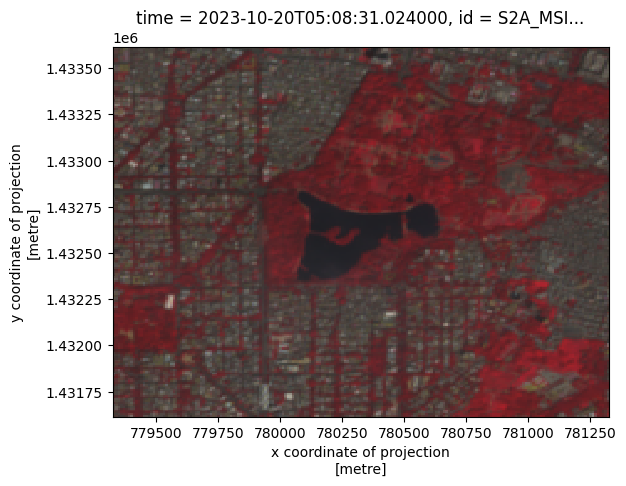

In [25]:
sentinel_stack.sel(band = ['B08','B04', 'B03']).isel(time=0).plot.imshow(robust=False)

In [106]:
import matplotlib.pyplot as plt
from skimage import exposure

def linear_stretch(arr, lower_percent=2, upper_percent=98):
    p_low, p_high = np.nanpercentile(arr, (lower_percent, upper_percent))
    clipped = np.clip(arr, p_low, p_high)
    return (clipped - p_low) / (p_high - p_low + 1e-8)  # add epsilon to avoid divide-by-zero


def histogram_equalization(arr_np):
    # arr_np is a NumPy array
    return exposure.equalize_hist(arr_np)

def minmax_normalization(arr):
    data = arr.data
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    norm = (data - min_val) / (max_val - min_val)
    return norm

def std_dev_stretch(arr, k=2):
    data = arr.data
    mean = np.nanmean(data)
    std = np.nanstd(data)
    lower = mean - k * std
    upper = mean + k * std
    stretched = np.clip(data, lower, upper)
    norm = (stretched - lower) / (upper - lower)
    return norm

band = ['B08', 'B04', 'B03']

array =  sentinel_stack.isel(time=11).sel(band=band)

percentage_stretch = xr.apply_ufunc(
    linear_stretch,
    array,  # your input xarray DataArray with dims ('band', 'y', 'x')
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,
    # dask="parallelized",  # optional, enables Dask compatibility
    output_dtypes=[array.dtype]  # or float32/float64 if you're normalizing
)

histeq_stretch = xr.apply_ufunc(
    histogram_equalization,
    array,  # your input xarray DataArray with dims ('band', 'y', 'x')
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,
    # dask="parallelized",  # optional, enables Dask compatibility
    output_dtypes=[array.dtype]  # or float32/float64 if you're normalizing
)

minmax_stretch = xr.apply_ufunc(
    minmax_normalization,
    array,  # your input xarray DataArray with dims ('band', 'y', 'x')
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,
    # dask="parallelized",  # optional, enables Dask compatibility
    output_dtypes=[array.dtype]  # or float32/float64 if you're normalizing
)

std_strech = xr.apply_ufunc(
    std_dev_stretch,
    array,  # your input xarray DataArray with dims ('band', 'y', 'x')
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,
    # dask="parallelized",  # optional, enables Dask compatibility
    output_dtypes=[array.dtype]  # or float32/float64 if you're normalizing
)

# 7. Display results
 

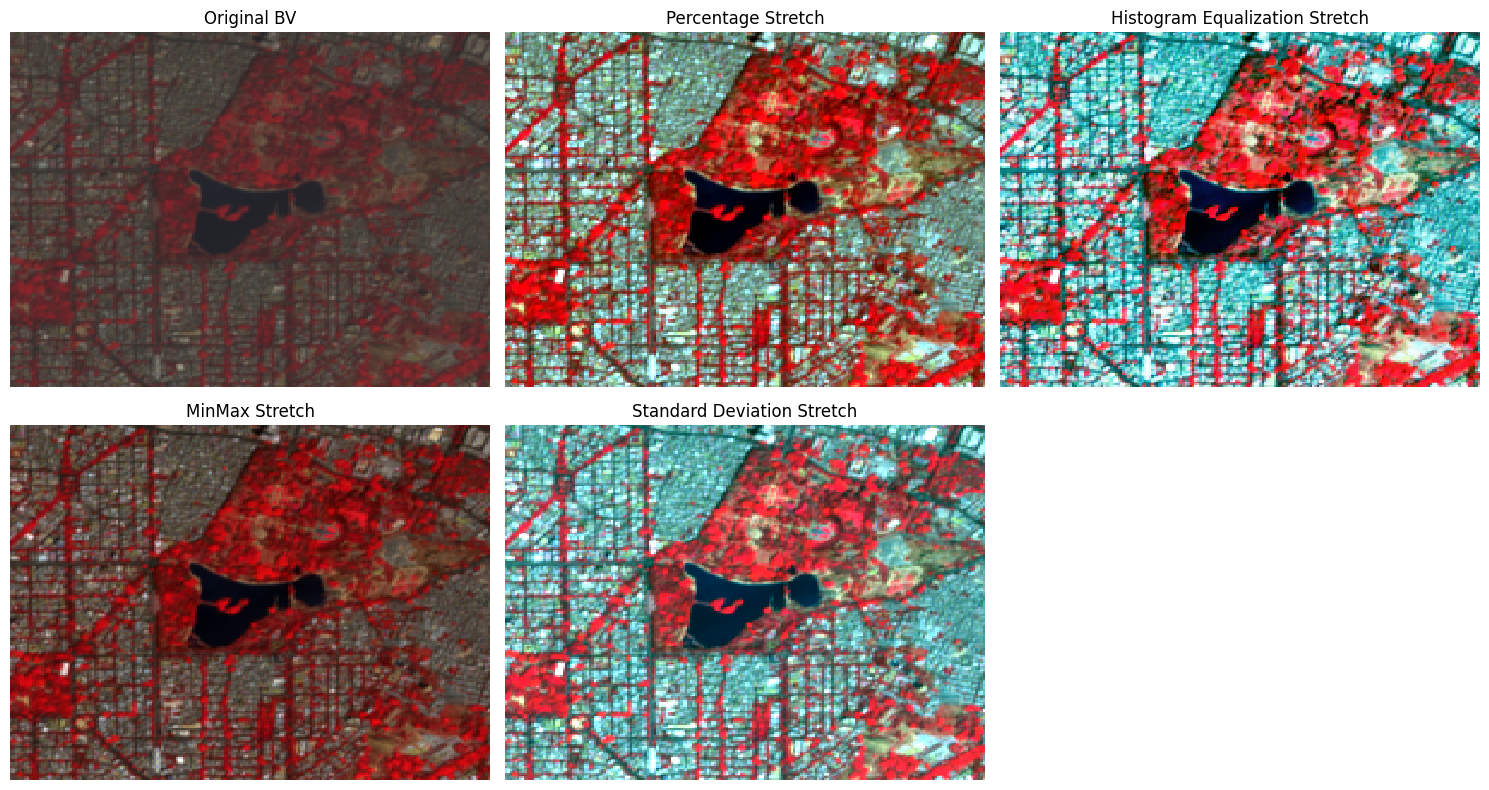

In [107]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns

# Flatten axes for easy indexing
axes = axes.flatten()

array.plot.imshow(ax=axes[0])
axes[0].set_title("Original BV")
axes[0].axis('off')

percentage_stretch.plot.imshow(ax=axes[1])
axes[1].set_title("Percentage Stretch")
axes[1].axis('off')

histeq_stretch.plot.imshow(ax=axes[2])
axes[2].set_title("Histogram Equalization Stretch")
axes[2].axis('off')

minmax_stretch.plot.imshow(ax=axes[3])
axes[3].set_title("MinMax Stretch")
axes[3].axis('off')

std_strech.plot.imshow(ax=axes[4])
axes[4].set_title("Standard Deviation Stretch")
axes[4].axis('off')

# Hide the unused 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()